In [1]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm


In [35]:
grid_width = 1
grid_height = 1
duration = 365

In [226]:
paramVariete = {
                # # récupérés depuis HV42 parameters
                "TBase":10,
                "TOpt1":25,
                "TOpt2":35,
                "TLim":40,

                # "VRacBVP":15.0,
                # "VRacPSP":15.0,
                # "VRacRPR":15.0,
                # "VRacMatu1":8.0,
                # "VRacMatu2":8.0,

                "SDJLevee":50,
                "SDJBVP":350, # 400
                "SDJRPR":300, # 400
                "SDJMatu1":300, # 400
                "SDJMatu2":50,

                # "kcMax":1.2,
                # "PFactor":0.5,
                # "seuilCstrMortality":3,
                # "PPSens":0.7,

                # 'txAssimMatu1':1,
                # 'txAssimMatu2':0.5,

                # 'txConversion':4, # 4 pour C4, 6 pour C4
                # 'kdf': 0.5, # Light extinction and conversion

                # "tempMaint":25,
                # "txResGrain":0.5,
                # "poidsSecGrain":0.028,
                # "aeroTotPente":1E-5,
                # "aeroTotBase":0.6,

                # "pcReallocFeuille":0.7,
                # "feuilAeroBase":0.6,

                # "KRdtPotA": 0.4,
                # "KRdtPotB": 200,

                # "txRealloc":0.5,
                # "slaMax":0.0060,
                # "slaMin":0.0018,
                

                # # pas dans le fichier de params
                # "VRacLevee":15.0, # pas dans les params
                # 'txAssimBVP':1,
                # "txRespMaint":0.2, # ????
                # "feuilAeroPente":1E-5, #???
                # "KRdtBiom":10, #?????
                # "slaPente":1,

                # # à vérifier
                
                }

paramITK = {
            "humSatMc":0, # humidité des résidus de couverture ?
            "biomIniMc":0, # Biomasse des résidues de couverture (Mulch). Unités : kg/ha
            "profRacIni":1, # mm
            "irrigAuto":False,
            # "irrigAutoTarget":0.5,
            # "maxIrrig":20,
            # "precision":0.1,
            "surfMc":0.0,
            "seuilEauSemis":0, # 5
            "mulch":10, # en pct integer [0-100]
            "coefMc":1,
            # "nbjTestSemis":3,
            # "seuilCstrMortality":10,
            "dateFin":300,
            # "densite":5000,
            }

paramTypeSol = {
                "ru":100, # en mm/m 
                "epaisseurSurf": 200, # en mm
                "epaisseurProf" : 1,
                "stockIniSurf":5,
                "stockIniProf":0.5,
                "seuilRuiss":1, # qté d'eau à partir de laquelle on entre dans un régime de ruissellement (mm)
                "pourcRuiss":0.5, # pourcentge de pluie qui ruisselle passé le seuil seuilRuiss (pct décimal)
                
                # 
                }

# ruRac = paramTypeSol["ru"] * paramITK["profRacIni"] / 1000 # alt name rRac
# ruSurf = paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]

In [167]:
# getting weather data
weatherdata = NASAPowerWeatherDataProvider(longitude=5, latitude=52)
print(weatherdata)
df_weather = pd.DataFrame(weatherdata.export())
df_weather = df_weather[(df_weather["DAY"]>=datetime.date(2020,1,1)) & (df_weather["DAY"]<=datetime.date(2020,1,1)+datetime.timedelta(days=duration-1))]
df_weather.head()

df_weather["DOY"] = df_weather.apply(lambda x: x["DAY"].timetuple().tm_yday, axis=1)
df_weather["ET0"] = df_weather["ET0"] * 10 #conversion cm to mm

df_weather["RAIN"] = df_weather["RAIN"] #conversion cm to mm

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER CERES/MERRA2 Native Resolution Daily Data
----Site characteristics----
Elevation:    3.5
Latitude:  52.000
Longitude:  5.000
Data available for 1984-01-01 - 2022-07-03
Number of missing days: 1



ordre des modules depuis SarrahV42.docx

In [168]:
def InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration): # depuis Bileau.pas
    
    # BiomMc := BiomIniMc;
    data["biomMc"] = np.full((grid_width, grid_height, duration), paramITK["biomIniMc"])
    
    # LitTiges := BiomIniMc;
    data["litTiges"] = np.full((grid_width, grid_height, duration), paramITK["biomIniMc"])

    # StSurf := StockIniSurf;
    data["stSurf"] = np.full((grid_width, grid_height, duration), paramTypeSol["stockIniSurf"])

    # Ltr := 1;
    data["ltr"] = np.full((grid_width, grid_height, duration), 1)

    # StRurMax := Ru * ProfRacIni / 1000;
    data["stRurMax"] = np.full((grid_width, grid_height, duration), (paramTypeSol["ru"] * paramITK["profRacIni"] / 1000))

    # RuSurf := EpaisseurSurf / 1000 * Ru;
    data["ruSurf"] = np.full((grid_width, grid_height, duration), (paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]))
    
    # //    PfTranspi := EpaisseurSurf * HumPf;
    # //    StTot := StockIniSurf - PfTranspi/2 + StockIniProf;

    # StTot := StockIniSurf  + StockIniProf;
    data["stTot"] = np.full((grid_width, grid_height, duration), (paramTypeSol["stockIniSurf"] + paramTypeSol["stockIniProf"]))
    
    # ProfRU := EpaisseurSurf + EpaisseurProf;
    data["profRu"] = np.full((grid_width, grid_height, duration), (paramTypeSol["epaisseurSurf"] + paramTypeSol["epaisseurProf"]))

    # // modif 10/06/2015  resilience stock d'eau
    # // Front d'humectation egal a RuSurf trop de stress initial
    # //    Hum := max(StTot, StRurMax);
    
    # Hum := max(RuSurf, StRurMax);
    # // Hum mis a profRuSurf
    # Hum := max(StTot, Hum);
    data["hum"] = np.full((grid_width, grid_height, duration),
        np.maximum(
            np.maximum(
                data["ruSurf"],
                data["stRurMax"],
            ),
            data["stTot"],
        )
    )
    
    # HumPrec := Hum;
    # StRurPrec := 0;
    # StRurMaxPrec := 0;
    # stRuPrec := stTot;
    # //modif 10/06/2015 resilience stock d'eau

    return data


In [169]:
def InitiationCulture(data, grid_width, grid_height, duration): # depuis MilBilanCarbone.pas
    

    # SommeDegresJourMaximale := SeuilTempLevee + SeuilTempBVP + SeuilTempRPR + SeuilTempMatu1 + SeuilTempMatu2;
    data["sommeDegresJourMaximale"] = np.full(
        (grid_width, grid_height, duration),
        (paramVariete["SDJLevee"] + paramVariete["SDJBVP"] + paramVariete["SDJRPR"] + paramVariete["SDJMatu1"] + paramVariete["SDJMatu2"])
    )

    # NumPhase := 0;
    # SommeDegresJour := 0;
    # BiomasseAerienne := 0;
    # BiomasseVegetative := 0;
    # BiomasseTotale := 0;
    # BiomasseTiges := 0;
    # BiomasseRacinaire := 0;
    # BiomasseFeuilles := 0;
    # DeltaBiomasseTotale := 0;
    # SeuilTempPhaseSuivante:=0;
    # Lai := 0;

    variables = [
        "numPhase",
        "sdj",
        "biomasseAerienne",
        "biomasseVegetative",
        "biomasseTotale",
        "biomasseTiges",
        "biomasseRacinaire",
        "biomasseFeuilles",
        "deltaBiomasseTotale",
        "seuilTempPhaseSuivante",
        "lai",
        
    ]

    for variable in variables :
        data[variable] = np.zeros(shape=(grid_width, grid_height, duration))

    return data

In [243]:
def InitSup(data, grid_width, grid_height, duration, df_weather, paramTypeSol):

    variables = [
        "ddj",
        "phasePhotoper",
        "changePhase",

        # irrig
        "correctedIrrigation",
        "stockIrr",
        "ruIrr",
        "irrigTotDay",
        "eauDispo",
        "sommeIrrig",
        "stockMc",
        "eauCaptee",
        "lr",
        "ruRac",
        "vRac",
        "cstr",
        "dayVrac",
        "deltaRur",
        "stockRac",
        "stRuMax",
        "stockSurface",
        "stRuSurfPrec",
        "eauTranspi",
        "stockTotal",
        "dr",
        "fesw",
        "kce",
        "evapPot",
        "FEMcW",
    ]

    for variable in variables :
        data[variable] = np.zeros(shape=(grid_width, grid_height, duration))

    data["tpMoy"] = df_weather["TEMP"].values.reshape(grid_width, grid_height, duration)
    data["rain"] = df_weather["RAIN"].values.reshape(grid_width, grid_height, duration)
    data["etp"] = df_weather["ET0"].values.reshape(grid_width, grid_height, duration)

    data["ru"] = np.full((grid_width, grid_height, duration), paramTypeSol["ru"])

    return data

In [171]:
def Meteo0DegToRad(): #pas indispensable
    return None

def Meteo1AVGTempHum(): # pas indispensable
    return None

def Meteo2Decli(): # pas indispensable
    return None

def Meteo3SunPosi():# pas indispensable
    return None

def Meteo4DayLength():# pas indispensable
    return None

def Meteo5SunDistance():# pas indispensable
    return None

def Meteo6RayExtra():# pas indispensable
    return None

def Meteo7RgMax():# pas indispensable
    return None

def Meteo8InsToRg():# pas indispensable
    return None

def Meteo9Par():# pas indispensable
    return None

def MeteoEToFAO():# pas indispensable
    return None



In [172]:
def EvolPhenoSarrahV3(j, data, paramITK): #depuis phenologie.pas
  
  """
    M�thode g�n�rique pour le test de fin de la phase photop�riodique.
  PhasePhotoper = 0 en fin de la phase photoper et = 1 en debut de la phase
  Cette proc�dure est appel�e en d�but de journ�e et fait �voluer les phase
  ph�nologiques. Pour cel�, elle incr�mente les num�ro de phase et change la
  valeur du seuil de somme de degr� jours de la phase suivante.
  ChangePhase est un bool�en permettant
  d'informer le mod�le pour conna�tre si un jour est un jour de changement
  de phase. Cel� permets d'initialiser les variables directement dans les
  modules sp�cifiques.
  --> Stades ph�nologiques pour les c�r�ales:
  // 0 : du jour de semis au d�but des conditions favorables pour la germination et de la r�colte � la fin de simulation (pas de culture)
  // 1 : du d�but des conditions favorables pour la germination au jour de la lev�e
  // 2 : du jour de la lev�e au d�but de la phase photop�riodique
  // 3 : du d�but de la phase photop�riodique au d�but de la phase reproductive
  // 4 : du d�but de la phase reproductive au d�but de la maturation (seulement pour le mais et riz) Pas pris en compte ici!
  //      sousphase1  de d�but RPR � RPR/4
  //      sousphase2  de RPR/4 � RPR/2
  //      sousphase3 de RPR/2 � 3/4 RPR
  //      sousphase4 de 3/4 RPR � fin RPR
  // 5 : du d�but de la maturation au stade grain laiteux
  // 6 : du d�but du stade grain laiteux au jour de r�colte
  // 7 : le jour de la r�colte
  Dans le cas des simulations pluriannuelles en continue, on ne r�initialise pas les r�servoirs, � la r�colte on met le front d'humectation � la profndeur du r�servoir de surface
  Cela permet de garder le ph�nom�ne de contrainte d'enracinement pour la saison suivante s'il y a peu de pluie
  tout en ayant le stock d'eau en profondeur restant de la saison pr�c�dente.
  """
    

  # if (Trunc(NumPhase) = 0) then
  # begin
  #   if ((StockSurface -RuSurf/10) >= SeuilPluie) then
  #   begin
  #     NumPhase := 1;
  #     ChangePhase := 1;
  #     SeuilTempPhaseSuivante := SeuilTempLevee;
  #   end;
  # end

  # test phase 0 - germination
  condition = (data["numPhase"][:,:,j] == 0) & (data["stSurf"][:,:,j] - data["ruSurf"][:,:,j] / 10 >= paramITK["seuilEauSemis"])

  data["numPhase"][:,:,j:] = np.where(condition, 1, data["numPhase"][:,:,j])
  data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j]) # changePhase remis à zéro à chaque appel de la procédure
  data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
    condition,
    paramVariete["SDJLevee"],
    data["seuilTempPhaseSuivante"][:,:,j],
  )

  # else # donc si numPhase != 0
  # begin
  #   if ((Trunc(NumPhase) = 2) and (SommeDegresJour >= SeuilTempPhaseSuivante)) then
  #   begin
  #     ChangementDePhase := True
  #   end

  # test phase 2
  condition = (data["numPhase"][:,:,j]==2) & (data["sdj"][:,:,j] >= data["seuilTempPhaseSuivante"][:,:,j])
  data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j])

  #   else # donc si numPhase != [0,2]
  #     begin
  #       If (Trunc(NumPhase) <> 3) Then
  #       begin
  #         ChangementDePhase := (SommeDegresJour >= SeuilTempPhaseSuivante)
  #       end

  # test phase 1, 4, 5, 6
  condition = (data["numPhase"][:,:,j] != 0) & (data["numPhase"][:,:,j] != 2) & (data["numPhase"][:,:,j] !=3 ) & (data["sdj"][:,:,j] >= data["seuilTempPhaseSuivante"][:,:,j])
  data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j])

  #       else
  #             begin
  #               ChangementDePhase := (PhasePhotoper = 0);
  #             end;

  # test phase 3
  condition = (data["numPhase"][:,:,j] == 3) & (data["phasePhotoper"][:,:,j] == 0)
  data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j])


  data["numPhase"][:,:,j:] = np.where(
    data["changePhase"][:,:,j] == 1,
    data["numPhase"][:,:,j] + 1 ,
    data["numPhase"][:,:,j],
  )

  # phase 1
  data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
      (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==1),
      paramVariete["SDJLevee"],
      data["seuilTempPhaseSuivante"][:,:,j]
  )

  # phase 2
  data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
      (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==2),
      data["seuilTempPhaseSuivante"][:,:,j] + paramVariete["SDJBVP"],
      data["seuilTempPhaseSuivante"][:,:,j]
  )  

  # phase 4
  data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
      (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==4),
      data["sdj"][:,:,j] + paramVariete["SDJRPR"],
      data["seuilTempPhaseSuivante"][:,:,j]
  ) 

  # phase 5
  data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
      (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==5),
      data["seuilTempPhaseSuivante"][:,:,j] + paramVariete["SDJMatu1"],
      data["seuilTempPhaseSuivante"][:,:,j]
  )

  # phase 6
  data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
      (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==6),
      data["seuilTempPhaseSuivante"][:,:,j] + paramVariete["SDJMatu2"],
      data["seuilTempPhaseSuivante"][:,:,j]
  )                                                    



  data["phasePhotoper"][:,:,j] = np.where(
      (data["changePhase"][:,:,j]==1) & (data["numPhase"][:,:,j]==3),
      1,
      data["phasePhotoper"][:,:,j],
  )  

  return data

In [173]:
def EvalDegresJourSarrahV3(j, data, paramVariete):
    """
    Pb de m�thode !?
    v1:= ((Max(TMin,TBase)+Min(TOpt1,TMax))/2 -TBase )/( TOpt1 - TBase);
    v2:= (TL - max(TMax,TOpt2)) / (TL - TOpt2);
    v:= (v1 * (min(TMax,TOpt1) - TMin)+(min(TOpt2,max(TOpt1,TMax)) - TOpt1) + v2 * (max(TOpt2,TMax)-TOpt2))/( TMax- TMin);
    DegresDuJour:= v * (TOpt1-TBase);
    """
    #     If Tmoy <= Topt2 then
    #      DegresDuJour:= max(min(TOpt1,TMoy),TBase)-Tbase
    #   else
    #      DegresDuJour := (TOpt1-TBase) * (1 - ( (min(TL, TMoy) - TOpt2 )/(TL -TOpt2)));
    #    If (Numphase >=1) then
    #         SomDegresJour := SomDegresJour + DegresDuJour
    #    else SomDegresJour := 0;


    # calcul des degrés jour
    data["ddj"][:,:,j] = np.where(
        data["tpMoy"][:,:,j] <= paramVariete["TOpt2"],
        np.maximum(np.minimum(paramVariete["TOpt1"], data["tpMoy"][:,:,j]), paramVariete["TBase"]) - paramVariete["TBase"],
        (paramVariete["TOpt1"] - paramVariete["TBase"]) * (1 - ((np.minimum(paramVariete["TLim"], data["tpMoy"][:,:,j]) - paramVariete["TOpt2"])
            / (paramVariete["TLim"] - paramVariete["TOpt2"]))),
    )  

    # calcul de la somme de degré jour
    data["sdj"][:,:,j] = np.where(
        data["numPhase"][:,:,j] >= 1,
        data["sdj"][:,:,j-1] + data["ddj"][:,:,j],
        0,
    )

    return data


In [174]:
def EvalIrrigPhase(j, data, paramITK):
    # eauDispo : Quantité journalière d'eau infiltrée dans le sol (moins le ruissellement). Unités : mm 
    
    if paramITK["irrigAuto"]==True : # && (numphase > 0) && (numphase < 6) )

        # pour StockIrr
        data["stockIrr"][:,:,j] = np.where(
            (data["numPhase"][:,:,j]>0) & (data["numPhase"][:,:,j]<6),
            np.where(
                (data["ruRac"][:,:,j] < data["ruSurf"][:,:,j]),
                data["stockSurface"][:,:,j],
                data["stockRac"][:,:,j],
                ),
            data["stockIrr"][:,:,j],
        )

        # pour ruIrr
        data["ruIrr"][:,:,j] = np.where(
            (data["numPhase"][:,:,j]>0) & (data["numPhase"][:,:,j]<6),
            np.where(
                (data["ruRac"][:,:,j] < data["ruSurf"][:,:,j]),
                data["ruSurf"][:,:,j],
                data["ruRac"][:,:,j],
                ),
            data["ruIrr"][:,:,j],
        )

        # pour irrigTotDay
        # on a retiré le calcul de l'arrondi selon la précision recherchée
        # on cast sur j
        data["irrigTotDay"][:,:,j] = np.where(
            (data["numPhase"][:,:,j]>0) & (data["numPhase"][:,:,j]<6) & (data["stockIrr"][:,:,j]/data["ruIrr"][:,:,j] < paramITK["irrigAutoTarget"]),
            np.minimum(np.maximum(0, ((data["ruIrr"][:,:,j] - data["stockIrr"][:,:,j]) * 0.9) - data["correctedIrrigation"][:,:,j]), paramITK["maxIrrig"]),
            data["irrigTotDay"][:,:,j],
        )

    data["irrigTotDay"][:,:,j] = data["correctedIrrigation"][:,:,j] + data["irrigTotDay"][:,:,j]		
    
    #data["sommeIrrig"][:,:,j:] = data["sommeIrrig"][:,:,j] + data["irrigTotDay"][:,:,j]


    # irrigTotDay remis à zéro tous les jours, on ne broadcast donc pas les valeurs
    
    
    return data

In [175]:
def PluieIrrig(j, data):
    data["eauDispo"][:,:,j] = data["rain"][:,:,j] + data["irrigTotDay"][:,:,j]
    return data

In [176]:
def RempliMc(j, data, paramITK):
    """
    Hypotheses :
    � chaque pluie on estime la quantit� d'eau pour saturer le couvert
    on la retire � l'Eaudispo (pluie + irrig)
    On calcul la capacit� maximum de stockage fn de la biomasse et du taux de saturation
    rapport�e en mm (HumSatMc en Kg H2O/Kg biomasse)
    La pluie est en mm unit� :
    1 mm = 1 litre d'eau / m2
    1 mm = 10 tonnes d'eau / hectare = 10 000 kg/ha
    La biomasse est en kg/ha pour se rapporter � la quantit� de pluie capt�e en mm
    KgH2O/Kg Kg/ha et kg/m� on divise par 10 000
    ( pour 3000 kg/ha � HumSat 2.8 kgH2O/kg on a un stockage max de 0.84 mm de pluie !??)
    Cette capacit� a capter est fn du taux de couverture du sol calcul� comme le LTR
    SurfMc est sp�cifi� en ha/t (0.39), on rapporte en ha/kg en divisant par 1000
    On retire alors les mm d'eau capt�es � la pluie incidente.
    Le ruisselement est ensuite calcul� avec l'effet de contrainte du mulch
    """
    
    data["eauCaptee"][:,:,j] = np.minimum(
        data["eauDispo"][:,:,j] * (1-np.exp(-paramITK["surfMc"] * data["biomMc"][:,:,j]/1000)),
        (paramITK["humSatMc"] * data["biomMc"][:,:,j]/ 10000) - data["stockMc"][:,:,j],
    )

    data["eauDispo"][:,:,j:] =  np.maximum(data["eauDispo"][:,:,j] - data["eauCaptee"][:,:,j], 0)
    data["stockMc"][:,:,j:] = data["stockMc"][:,:,j] + data["eauCaptee"][:,:,j]

    return data

In [177]:
def EvalRunOff(j, data, paramTypeSol):

    """
    // CB 2014
    On a regroup� avant la pluie et l'irrigation (a cause de l'effet Mulch)
    si mulch on a enlev� l'eau capt�e
    oN CALCUL SIMPLEMENT LE RUISSELLEMENT EN FN DE SEUILS
    }
    """

    # lr est reset a zéro en début de calcul, on ne broadcast pas les valeurs
    data["lr"][:,:,j] = np.where(
        data["rain"][:,:,j] > paramTypeSol["seuilRuiss"],
        (data["eauDispo"][:,:,j]  - paramTypeSol["seuilRuiss"]) *  paramTypeSol["pourcRuiss"],
        0, #data["lr"][:,:,j],
    )

    data["eauDispo"][:,:,j:] = data["eauDispo"][:,:,j] - data["lr"][:,:,j]

    return data

In [178]:

def EvolRurCstr2(j, data, paramITK):

    """
    Modif 10/06/2015  Stres trop fort enracinement
    Trop d'effet de stress en tout d�but de croissance :
    1) la plantule a des r�serves et favorise l'enracinement
    2) dynamique sp�cifique sur le r�servoir de surface
    Cet effet stress sur l'enracinement ne s'applique que quand
    l'enracinement est sup�rieur � la profondeur du r�servoir de surface.
    Effet stres a un effet sur la vitesse de prof d'enracinement au dessus
    d'un certain seuil de cstr (on augmente le cstr de 0.3
    pour que sa contrainte soit affaiblie sur la vitesse)
    La vitesse d'enracinement potentielle de la plante peut etre bloque
    par manque d'eau en profondeur (Hum). La profondeur d'humectation
    est convertie en quantite d'eau maximum equivalente
    // Parametres
    IN:
    Vrac : mm
    Hum : mm
    StRuSurf : mm
    RU : mm/m
    RuSurf : mm/m
    INOUT:
    stRurMax : mm
    stRur : mm
    """

    # dayvrac et deltarur reset à chaque itération ; on traine donc le j sur les autres variables

    # rurac test 1
    data["ruRac"][:,:,j] = np.where(
        (data["changePhase"][:,:,j]==True) & (data["numPhase"][:,:,j]==1),
        paramITK["profRacIni"]/1000*data["ru"][:,:,j],
        data["ruRac"][:,:,j],
    )

    # dayvrac
    #on met à jour la vitesse de croissance racinaire
    # en date de changement de stade, pour le stade = 1, et si la réserve utile racinaire est supérieure
    # à la réserve utile de surface, on met à jour vRac pour que la nouvelle valeur soit contrainte par cstr
    data["dayVrac"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j]>0) & np.invert((data["changePhase"][:,:,j]==True) & (data["numPhase"][:,:,j]==1)) & (data["ruRac"][:,:,j]>data["ruSurf"][:,:,j]),
        (data["vRac"][:,:,j] * np.minimum(data["cstr"][:,:,j] + 0.3, 1.0)) / 1000 * data["ru"][:,:,j],
        data["dayVrac"][:,:,j],
    )
    
    # deltarur fait des pics car hum est à plat ?
    # hum est à plat parce que stocktotal est à plat ?
    # deltarur
    data["deltaRur"][:,:,j] = np.where(
        (data["numPhase"][:,:,j]>0) & (data["changePhase"][:,:,j]==True) & (data["numPhase"][:,:,j]==1),
        data["deltaRur"][:,:,j],    
        np.where(
            (data["ruRac"][:,:,j]>data["ruSurf"][:,:,j]),
            np.where(
                (data["hum"][:,:,j] - data["ruRac"][:,:,j]) < data["dayVrac"][:,:,j],
                data["hum"][:,:,j] - data["ruRac"][:,:,j],
                data["dayVrac"][:,:,j],
            ),
            data["vRac"][:,:,j]/1000*data["ru"][:,:,j],
        ),
    )

    # rurac2
    data["ruRac"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j]>0),
        np.where(
            (data["changePhase"][:,:,j]==True) & (data["numPhase"][:,:,j]==1),
            data["ruRac"][:,:,j],
            data["ruRac"][:,:,j] + data["deltaRur"][:,:,j],
        ),
        data["ruRac"][:,:,j],
    )
        
    #stockrac
    data["stockRac"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j]>0) & np.invert((data["changePhase"][:,:,j]==True) & (data["numPhase"][:,:,j]==1)),
        np.where(
            (data["ruRac"][:,:,j]>data["ruSurf"][:,:,j]),
            data["stockRac"][:,:,j] + data["deltaRur"][:,:,j],
            np.maximum((data["stockRac"][:,:,j] - data["ruSurf"][:,:,j] / 10) * (data["ruRac"][:,:,j] / data["ruSurf"][:,:,j]), 0),
        ),
        data["stockRac"][:,:,j],
    )


    return data

In [199]:
def rempliRes(j, data):

    # eautranspi est reset à chaque itération à 0
    # stRUmax est reset à la valeur ru à chaque itération
    # on ne cast donc pas ces variables sur j

    data["stRuMax"][:,:,j] = data["ru"][:,:,j] * data["profRu"][:,:,j] / 1000
    
    # on met à jour le stock de surface
        # on cast sur j

    data["stRuSurfPrec"][:,:,j] = data["stockSurface"][:,:,j]
    
    # on met à jour le stock d'eau en surface pour qu'il corresponde au stock de surface mis à jour
    # par l'eau disponible, borné au max par 110% de la réserve utile de surface.
    # on transmet donc la valeur sur j
    # ConsoResSep agit aussi sur cette variable
    data["stockSurface"][:,:,j:] = np.minimum(
        data["stockSurface"][:,:,j] + data["eauDispo"][:,:,j],
        data["ruSurf"][:,:,j] + data["ruSurf"][:,:,j] /10
    )

    # si le stock de surface à j-1 est inférieur à 10% de la réserve utile de surface, 
    # la quantité d'eau transpirable correspond à l'eau disponible moins la différence 
    # entre 1/10e de la réserve utile de surface et le stock de surface, bornée au minimum par 0,
    # sinon la quantité d'eau transpirable est égale à l'eau disponible
        # on cast sur j
    data["eauTranspi"][:,:,j] = np.where(
        data["stRuSurfPrec"][:,:,j] < data["ruSurf"][:,:,j]/10,
        np.maximum(
            0,
            data["eauDispo"][:,:,j] - (data["ruSurf"][:,:,j]/10 - data["stRuSurfPrec"][:,:,j])
            ),
        data["eauDispo"][:,:,j],
    )

    # on met à jour le stock d'eau total sur l'ensemble des réservoirs
    # en ajoutant l'eau transpirable
    # on transmet donc la valeur sur j
    data["stockTotal"][:,:,j:] = data["stockTotal"][:,:,j] + data["eauTranspi"][:,:,j]


    # on met à jour le drainage au delà de la profondeur maximum du réservoir (mm/j) :
    # si le stock total est supérieur à la réserve utile maximale,
    # le drainage vaut la différence entre le stock total et la réserve utile maximale,
    # il est nul sinon
        # on cast sur j
    data["dr"][:,:,j:] = np.where(
        data["stockTotal"][:,:,j] > data["stRuMax"][:,:,j],
        data["stockTotal"][:,:,j] - data["stRuMax"][:,:,j],
        0,
    )

    # on met à jour le stock total (mm) pour le borner par la réserve utile maximale
    # si le stock total est supérieur à la réserve utile maximale du sol, il vaut cette réserve utile max
    # sinon on ne touche pas la valeur
        # on cast sur j
    data["stockTotal"][:,:,j:] = np.where(data["stockTotal"][:,:,j] > data["stRuMax"][:,:,j],
        data["stRuMax"][:,:,j],
        data["stockTotal"][:,:,j],
    )

    # on met à jour la quantité d'eau maximale jusqu'au front d'humectation (mm)
    # on retient à chaque point de temps la valeur max entre la valeur hum précédente et le stock total
        # on cast sur j
    data["hum"][:,:,j:] = np.maximum(data["hum"][:,:,j], data["stockTotal"][:,:,j])


    # on met à jour le Stock d'eau disponible pour la plante das la zone racinaire
    # le stock en zone racinaire est donc le stock total borné au maximum par la réserve utile racinaire, 
    # et borné au maximum par le stock d'eau racinaire
    #? on n'a pas ajouté deux fois l'eautranspi dans stocktotal ? 
    # data["stockRac"][:,:,j] = np.minimum(np.minimum(data["stockTotal"][:,:,j] + data["eauTranspi"][:,:,j], data["ruRac"][:,:,j]), data["stockTotal"][:,:,j])
        # on cast sur j
    data["stockRac"][:,:,j] = np.minimum(np.minimum(data["stockTotal"][:,:,j], data["ruRac"][:,:,j]), data["stockTotal"][:,:,j])
    

    return data

In [215]:
def EvalFESW(j, data):
    """
    Estimation de la fraction d'eau evaporable, rapporte donc au reservoir
    de surface, RuSurf est le stock d'eau maxi disponible pour la plante
    sur ce reservoir
    Modif : on considere que pour l'�vaporation la moitie de cette
    valeur doit etre ajout�e.
    // Parametres
    IN:
    StRusurf : mm
    RuSurf : mm
    OUT:
    fesw : mm
    """

    data["fesw"][:,:,j] = data["stockSurface"][:,:,j] / (data["ruSurf"][:,:,j] * 1.1)

    return data

In [221]:
def EvalKceMc(j, data, paramITK):
    """
    Trois possibilit�s d'extinction sur l'�vaporation :
    ltr : couverture de la plante
    Mulch : effet couvrant permanent et constant; 100 pas de Mulch, 0 couvert complet bache)
    exp() �quivalent � formule de calcul du ltr mais appliqu� � l'effet couvrant d'un
    mulch couvert de paillis... �volutif
    """

    # Kce := Mulch/100 * ltr * exp(-coefMc * SurfMc * BiomMc/1000);
    data["kce"][:,:,j] = paramITK["mulch"] / 100 * data["ltr"][:,:,j] * np.exp(-paramITK["coefMc"] * paramITK["surfMc"] * data["biomMc"][:,:,j]/1000)
    
    return data

In [232]:
def DemandeSol(j, data):
    """
    Estimation de l'evaporation potentielle du sol, on ne tient pas
    compte d'une variation de l'evaporation en fonction d'une humectation
    differente entre le haut et le bas du reservoir, on a un parametre
    mulch qui peu traduire le phenomene d'auto mulching (defaut : 0.7)
    qui peu aussi traduire un mulch par couverture vegetale ou...
    La reduction de l'evaporation par l'evolution de la couverture
    du sol par la plante est traduit par ltr.

    // Parametres
    IN:
    ETo : mm
    Kce : %
    OUT:
    evapPot : mm
    """
    data["evapPot"][:,:,j:] = data["etp"][:,:,j] * data["kce"][:,:,j]

    return data

In [239]:
def EvapMc(j, data, paramITK):
    """
    comme pour FESW on retire du stock la fraction evaporable
    la demande climatique �tant r�duite � la fraction touchant le sol ltr
    on borne � 0
    """
    #If StockMc > 0 then FEMcW := (HumSatMc * BiomMc * 0.001)/StockMc;
    # StockMc := max (0, StockMc - ltr * Eto * FEMcW * FEMcW);

        # evapMc
    # on met à jour FEMcW
    # si le stock de mulch est supérieur à 0, femcw  est calculé à partir de l'humidité, de la biomasse
    # et du stock d'eau du mulch
        # on cast sur j
    data["FEMcW"][:,:,j:] = np.where(
        data["stockMc"][:,:,j]>0,
        (paramITK["humSatMc"] * data["biomMc"][:,:,j] * 0.001) / data["stockMc"][:,:,j],
        data["FEMcW"][:,:,j],
    )

    # on met à jour le stock d'eau dans le mulch 
    # si le stock d'eau est non-nul, on
    # bornée au minimum par 0
    # attention, confusion dans le script original entre les variables ltr (rayonnement transmis au sol) et lt (ruissellement journalier) ???
        # on cast sur j
    data["stockMc"][:,:,j:] = np.where(
        data["stockMc"][:,:,j] > 0,
        # np.maximum(0, data["stockMc"][:,:,j] - data["ltr"][:,:,j] * data["etp"][:,:,j] * data["FEMcW"][:,:,j]**2),
        np.maximum(0, data["stockMc"][:,:,j] - data["lr"][:,:,j] * data["etp"][:,:,j] * data["FEMcW"][:,:,j]**2),
        data["stockMc"][:,:,j],
    )

    return data

# Run

In [244]:
data = {}
data = InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration)
data = InitiationCulture(data, grid_width, grid_height, duration)
data = InitSup(data, grid_width, grid_height, duration, df_weather, paramTypeSol)

for j in range(duration):
    data = EvolPhenoSarrahV3(j, data, paramITK)
    data = EvalDegresJourSarrahV3(j, data, paramVariete)
    data = EvolPhenoSarrahV3(j, data, paramITK)
    data = EvalIrrigPhase(j, data, paramITK)
    data = PluieIrrig(j, data)
    data = RempliMc(j, data, paramITK)
    data = EvalRunOff(j, data, paramTypeSol)
    data = EvolRurCstr2(j, data, paramITK)
    data = rempliRes(j, data)
    data = EvalFESW(j, data)
    data = EvalKceMc(j, data, paramITK)
    data = DemandeSol(j, data)
    data = EvapMc(j, data, paramITK)

/tmp/ipykernel_479/1477802637.py:17: RuntimeWarning: invalid value encountered in divide
  (paramITK["humSatMc"] * data["biomMc"][:,:,j] * 0.001) / data["stockMc"][:,:,j],


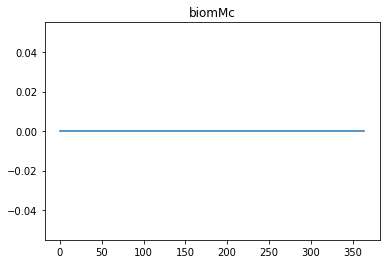

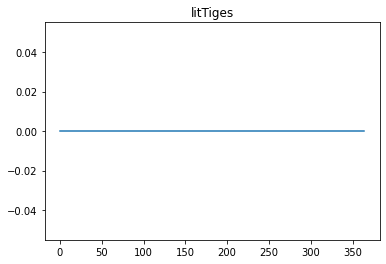

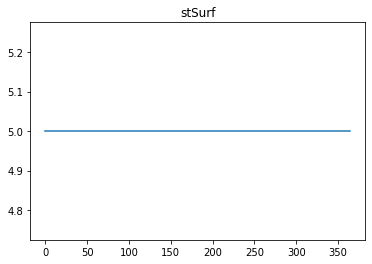

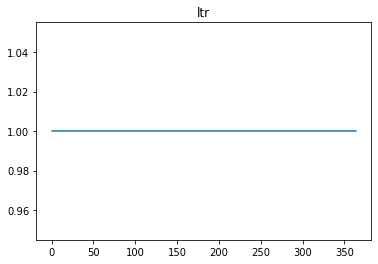

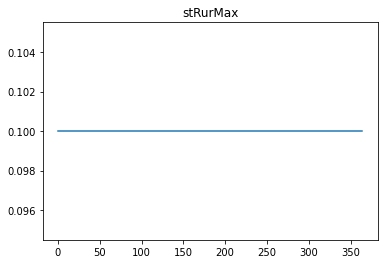

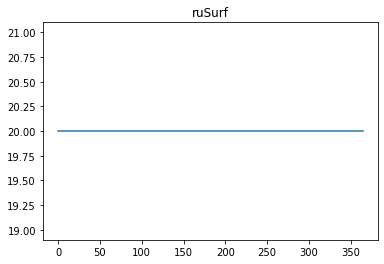

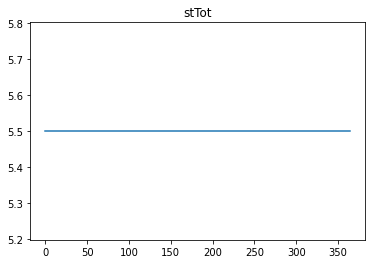

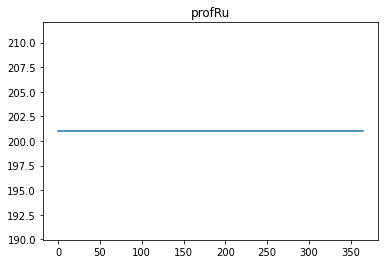

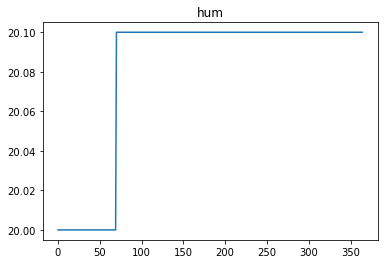

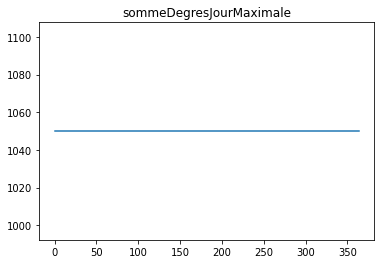

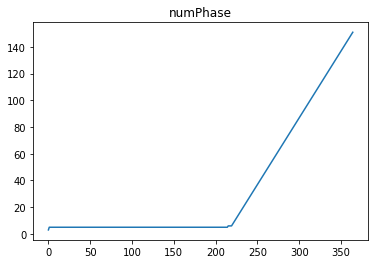

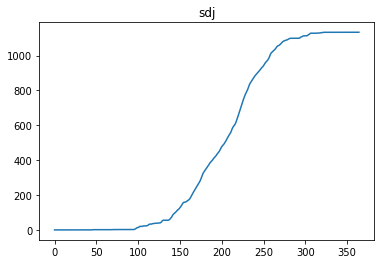

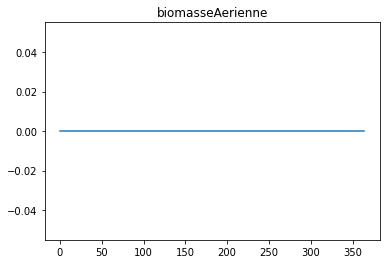

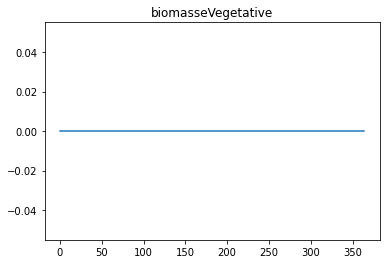

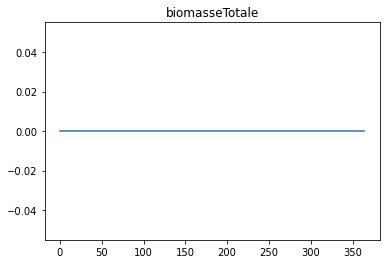

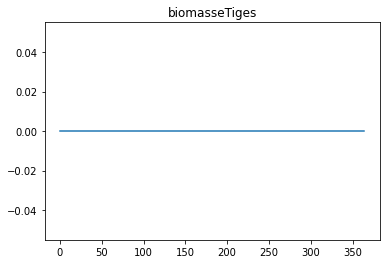

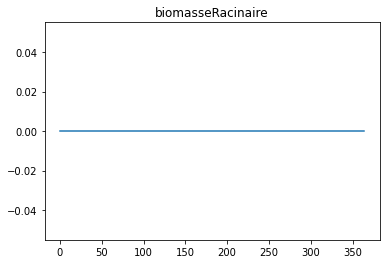

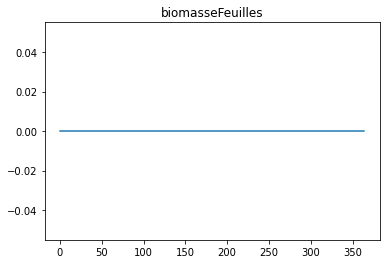

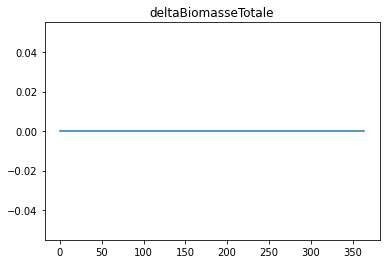

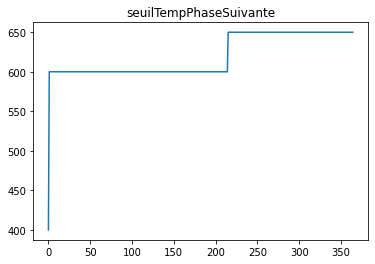

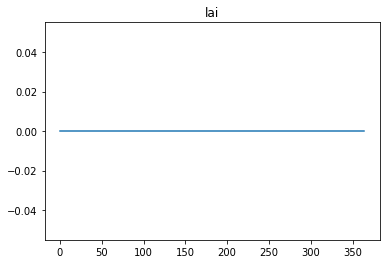

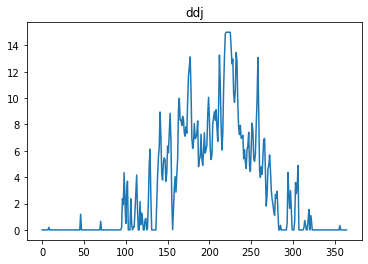

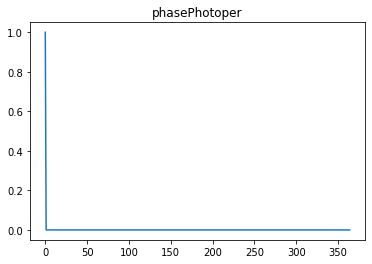

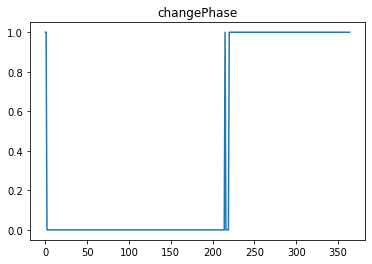

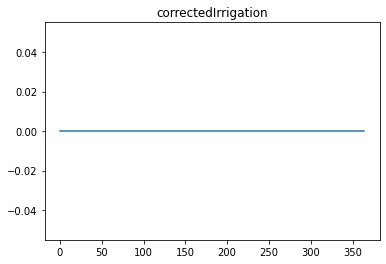

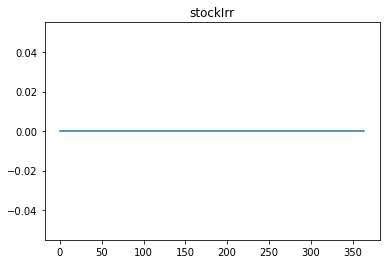

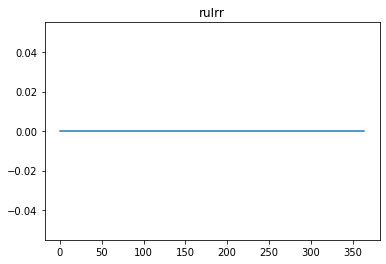

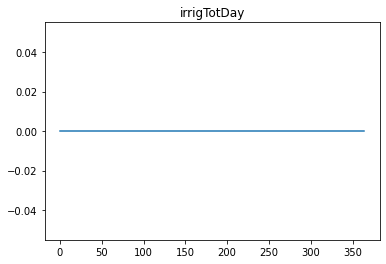

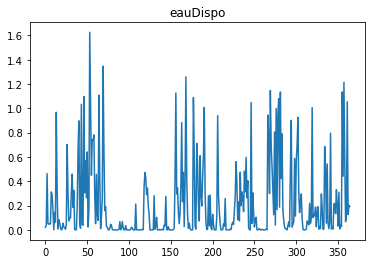

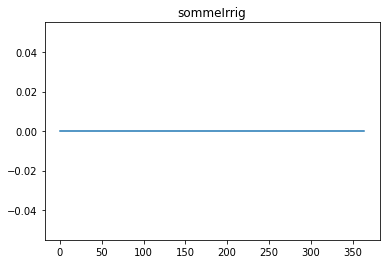

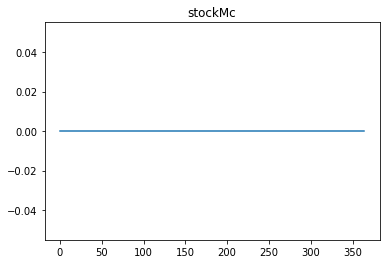

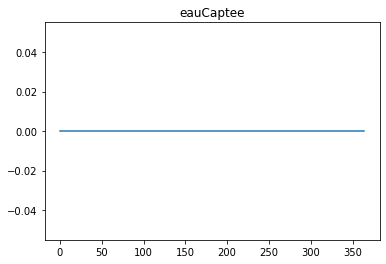

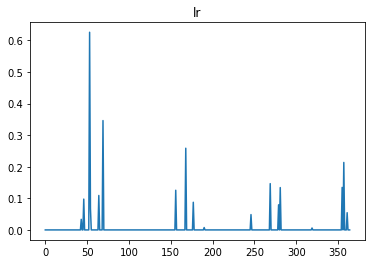

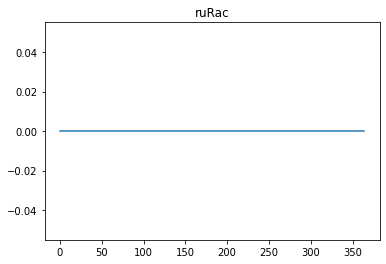

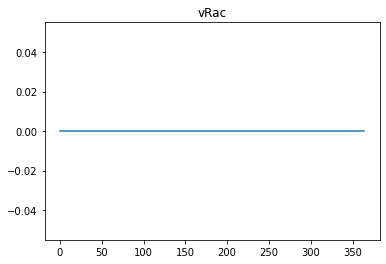

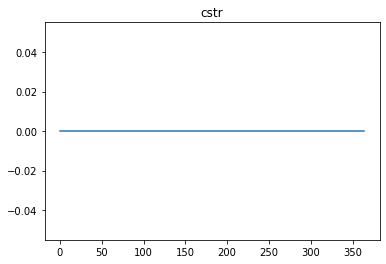

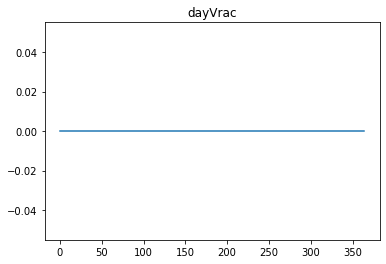

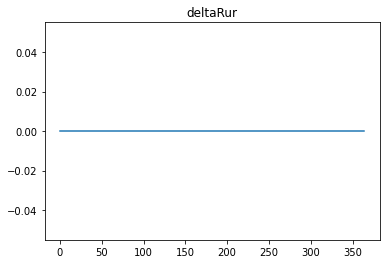

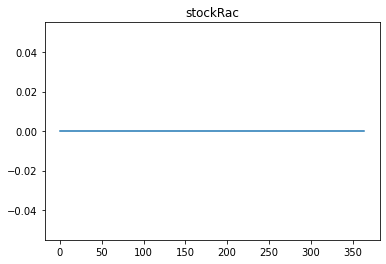

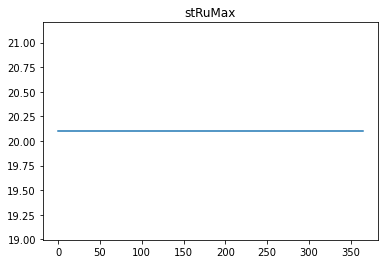

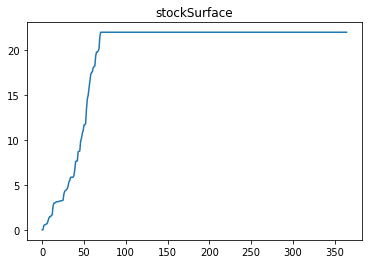

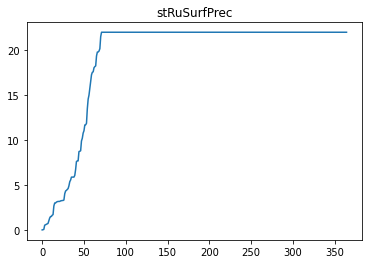

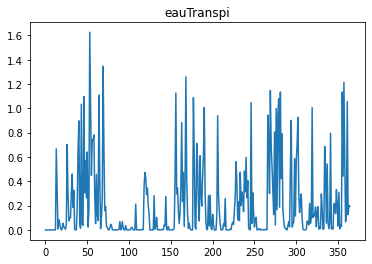

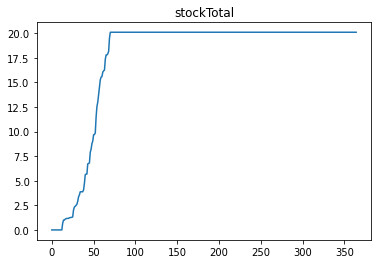

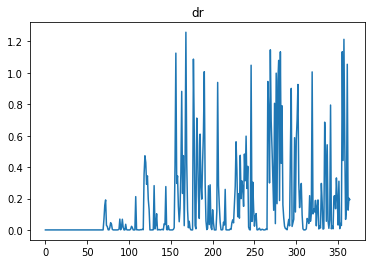

In [245]:
for variable in list(data) :
    plt.plot(data[variable][0,0,:])
    plt.title(variable)
    plt.show()